# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Badyn Milstein-Touesnard, Isabel Camara, Mateo Aranzazu

**ID**: 5286287, 5273977, 5355552

**netD**: bmm98, ic277 , ma956

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [141]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Measures")

In [142]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames
using Measures

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

In [143]:
#define river properties
U = 6          #km/day
Cs = 10        #general saturation level
ka= .55        #day^-1
kc = .35 
kn = .25 

# River Concentrations
Cr_DO = 7.5    # mg/L
Cr_CBOD = 5
Cr_NBOD = 5

# waste stream 1
Cw1_DO = 5
Cw1_CBOD = 50
Cw1_NBOD = 35

Qr = 100000     # m3/d
Qw1 = 10000     # m3/d
Cw2_DO = 5
Cw2_CBOD = 45
Cw2_NBOD = 35
Qw2 = 15000     #m3/d


15000

## Defining Variables

Variables marked with Cr are associated with the river before mixing, Cw1 refers to waste stream 1 before mixing, C0 (dissolved oxygen), N0 (Nitrogen BOD), and B0 (CBOD) are at 0km when waste stream 1 and the river first mix.

C15, CBOD_15, and NBOD_15 are at 15km before mixing with waste stream 2.

Cw2 variables refer to waste stream 2 before any mixing.

C1, N1, and B1 refer to 15km after waste stream 2 mixes into the river.

See attatched diagram for a clear picture of where each variable occurs.

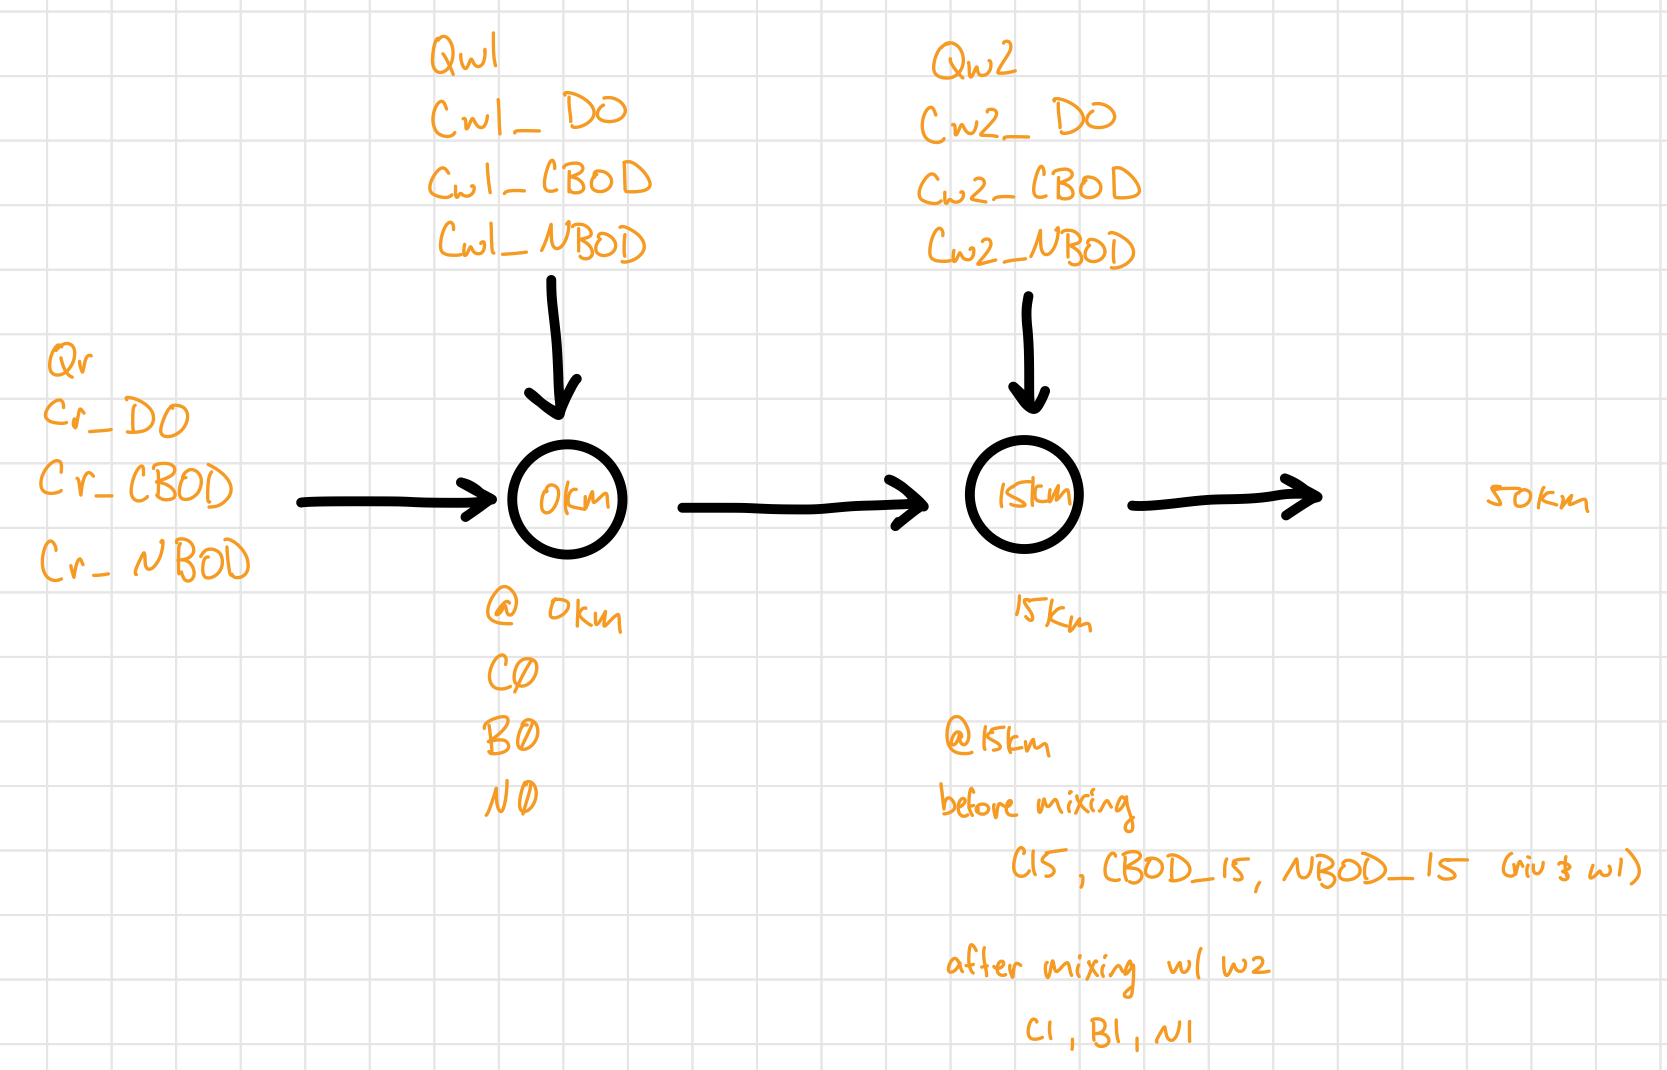

## Initial mixing

To get the initial concentration after the river and waste stream 1 mix at 0km we used the following equations:

$C_0 = \frac{(C_{r\_DO} \cdot Q_r) + (C_{w1\_DO} \cdot Q_{w1})}{Q_r + Q_{w1}}$

$B_0 = \frac{(C_{r\_CBOD} \cdot Q_r) + (C_{w1\_CBOD} \cdot Q_{w1})}{Q_r + Q_{w1}}$

$N_0 = \frac{(C_{r\_NBOD} \cdot Q_r) + (C_{w1\_NBOD} \cdot Q_{w1})}{Q_r + Q_{w1}}$

The function do_simulate simulates the dissolved oxygen levels based on the streeter phelps equation. The function takes in $x,Cs,C0,B0,N0,ka,kc,kn,U$ and returns, C, the dissolved oxygen concentration at each kilometer throughout from 0km to 15km. 

$a_1 = \exp\left(-\frac{ka \cdot x}{U}\right)$

$a_2 = \left(\frac{kc}{ka - kc}\right) \left(\exp\left(-\frac{kc \cdot x}{U}\right) - \exp\left(-\frac{ka \cdot x}{U}\right)\right)$

$a_3 = \left(\frac{kn}{ka - kn}\right) \left(\exp\left(-\frac{kn \cdot x}{U}\right) - \exp\left(-\frac{ka \cdot x}{U}\right)\right)$

$C = Cs \cdot \left(1 - a_1\right) + C_0 \cdot a_1 - B_0 \cdot a_2 - N_0 \cdot a_3$


After calculating this we are able to calculate the mixing at 15km with waste stream 2. To do this we find the concentration of each DO, NBOD, and CBOD before waste stream 2 mixes into the river at 15km. The equations are as follows for CBOD and NBOD and the DO is found by calling the 16th term of the C output from the do_simulate function.

$CBOD_{15} = B_0 \cdot \exp\left(-\frac{kc \cdot 15}{U}\right)$

$NBOD_{15} = N_0 \cdot \exp\left(-\frac{kc \cdot 15}{U}\right)$

Then using those values as inputs we calculate each of the concentrations at 15km after mixing with waste stream 2:

$C_1 = \frac{(C_{15} \cdot (Q_r + Q_{w1}) + C_{w2\_DO} \cdot Q_{w2})}{Q_r + Q_{w1} + Q_{w2}}$

$B_1 = \frac{(CBOD_{15} \cdot (Q_r + Q_{w1}) + C_{w2\_CBOD} \cdot Q_{w2})}{Q_r + Q_{w1} + Q_{w2}}$

$N_1 = \frac{(NBOD_{15} \cdot (Q_r + Q_{w1}) + C_{w2\_NBOD} \cdot Q_{w2})}{Q_r + Q_{w1} + Q_{w2}}$




After that the function do_simulate_2 simulates the DO sag curve from 15km to 50km after waste stream 2 is mixed into the river. It uses the streeter phelps equation as well but instead uses C1, B1, and N1 as inputs for C, B, and N. You evaluate this over 15-50km to get the DO level at every kilometer. do_simulate_2 uses the DO function as follows:

$C = Cs \cdot \left(1 - a_1\right) + C_1 \cdot a_1 - B_1 \cdot a_2 - N_1 \cdot a_3$

We used broadcasting on both do_simulate and do_simulate_2 to calculate the functions over the given distances desired.

In [144]:

#Find Mixing Variables
C0 = ((Cr_DO*Qr)+(Cw1_DO*Qw1))/(Qr+Qw1) #DO Concentration
B0 = ((Cr_CBOD*Qr)+(Cw1_CBOD*Qw1))/(Qr+Qw1) #CBOD concentration
N0 = ((Cr_NBOD*Qr)+(Cw1_NBOD*Qw1))/(Qr+Qw1) #NBOD concentration


function do_simulate(x,Cs,C0,B0,N0,ka,kc,kn,U)
    #create formulas for mixing river and stream 1 based on Streeter-Phelps model
    a_1 = exp(-ka*x/U)
    a_2 = (kc/(ka-kc))*(exp(-kc*x/U)-exp(-ka*x/U))
    a_3 = (kn/(ka-kn))*(exp(-kn*x/U)-exp(-ka*x/U))
    C = Cs*(1-a_1)+C0*(a_1)-B0*(a_2)-N0*(a_3)

    return C
end

#DO concentration at 15 km
conc_15km = (do_simulate(15,Cs,C0,B0,N0,ka,kc,kn,U))

C15 = conc_15km
CBOD_15 = B0*exp(-kc*15/U)
NBOD_15 = N0*exp(-kc*15/U)



x = 0:15
C = (y -> do_simulate(y,Cs,C0,B0,N0,ka,kc,kn,U)).(x);


In [145]:

#Now consider river + stream 1 mixing with stream 2
C1 = ((C15*(Qr+Qw1))+(Cw2_DO*Qw2)) / (Qr+Qw1+Qw2) #DO Concentration
B1 = ((CBOD_15*(Qr+Qw1))+(Cw2_CBOD*Qw2))/(Qr+Qw1+Qw2) #CBOD concentration
N1 = ((NBOD_15*(Qr+Qw1))+(Cw2_NBOD*Qw2))/(Qr+Qw1+Qw2) #NBOD concentration


d = 15:50

function do_simulate_2(d,Cs,C1,B1,N1,ka,kc,kn,U)
    # create formulas for mixing river, stream 1, and stream 2 based on Streeter-Phelps model
    a1 = exp(-ka * d / U)
    a2 = (kc/(ka-kc)) * (exp(-kc * d / U) - exp(-ka * d / U))
    a3 = (kn/(ka-kn)) * (exp(-kn * d / U) - exp(-ka * d / U))
    C_2 = Cs * (1 - a1) + C1 * a1 - B1 * a2 - N1 * a3

    return C_2
end

C_2 = (y -> do_simulate_2(y-15,Cs,C1,B1,N1,ka,kc,kn,U)).(d);

**Plot of DO from first waste stream to 50km downriver**:

In [173]:
using Plots
using LaTeXStrings

# plot outputs
p1 = plot([x;d], [C;C_2]; label=["DO"], xlabel="x (km)", ylabel="DO Concentration (mg/L)", show = true)
#plot(dist, y_vals, show=true)

# Add horizontal line for the regulatory standard
hline!([4], color=:red, linewidth=2, label="Regulatory Standard")
display(p1)

BoundsError: BoundsError: attempt to access 17-element Vector{Float64} at index [1:52]

**Minimum DO**:

From inspection of the plot, we can see that the minimum dissolved oxygen exists in our second function do_simulate_2 which is stored in C_2. Thus, we perform the minimum function on C_2 to identify the value. The minimum dissolved oxygen in this scenario comes out to 3.76 mg/L. 

In [147]:
min_DO = minimum(C_2)
@show min_DO

3.90549105089992

Minimum level of treatment (% removal of organic waste) for waste stream 1 that will ensure that the dissolved oxygen concentration never drops below 4 mg/L, assuming that waste stream 2 remains untreated?

## Percent Removed Calculation

In [174]:
# Stream 1

for i in 1:-0.01:0
    percent_removed = i
    
    B0_treat = ((Cr_CBOD * Qr) + (Cw1_CBOD * Qw1 * percent_removed)) / (Qr + Qw1) #apply a treatment percentage amount of CBOD loading
    N0_treat = ((Cr_NBOD * Qr) + (Cw1_NBOD * Qw1 * percent_removed)) / (Qr + Qw1) #apply a treatment percentage amount of NBOD loading 
    
    C15 = [do_simulate(i,Cs,C0, B0_treat, N0_treat,ka,kc,kn,U) for i in flow_range][16]
    CBOD_15 = B0_treat*exp(-kc*15/U)
    NBOD_15 = N0_treat*exp(-kc*15/U)
    
    
    B1_Treatment = ((CBOD_15*(Qr+Qw1)) + (Cw2_CBOD*Qw2))/(Qr+Qw1+Qw2) #apply a treatment percentage amount of CBOD loading
    N1_Treatment = ((NBOD_15*(Qr+Qw1)) + (Cw2_NBOD*Qw2))/(Qr+Qw1+Qw2) #apply a treatment percentage amount of NBOD loading 
    
    treatment_DO = [do_simulate_2(i,Cs,C1,B1_Treatment,N1_Treatment,ka,kc,kn,U) for i in flow_range_2]

    DO = minimum(treatment_DO)
    if all(c > 4 for c in treatment_DO)
        display(DO)
        display((1-i)*100)
        break
    end 

end

4.004413486300837

16.000000000000004

In [175]:
# waste stream 2
C15 = (do_simulate(15,Cs,C0,B0,N0,ka,kc,kn,U))
CBOD_15 = B0*exp(-kc*15/U)
NBOD_15 = N0*exp(-kn*15/U)

# Concentrations after mixing
C1 = ((C15*(Qr+Qw1))+(Cw2_DO*Qw2)) / (Qr+Qw1+Qw2)


flow_range = 0:15 #range of first stream
flow_range_2 = 0:35

for i in 1:-0.01:0
    percent_removed = i
    B1_Treatment = ((CBOD_15*(Qr+Qw1)) + (Cw2_CBOD*Qw2*percent_removed))/(Qr+Qw1+Qw2) #apply a treatment percentage amount of CBOD loading
    N1_Treatment = ((NBOD_15*(Qr+Qw1)) + (Cw2_NBOD*Qw2*percent_removed))/(Qr+Qw1+Qw2) #apply a treatment percentage amount of NBOD loading 
    
    treatment_DO = [do_simulate_2(i,Cs,C1,B1_Treatment,N1_Treatment,ka,kc,kn,U) for i in flow_range_2]

    DO = minimum(treatment_DO)
    if all(c > 4 for c in treatment_DO)
        display(DO)
        display((1-i)*100)
        break
    end 
end


4.007015974604083

12.0

Suppose you are responsible for designing a waste treatment plan for discharges into the river, with a regulatory mandate to keep the dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt to treat waste stream 2 alone or both waste streams equally. What other information might you need to make a conclusion, if any?

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [152]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

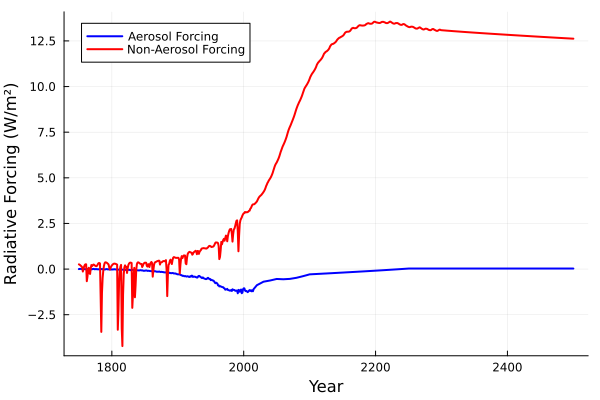

In [153]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**Discretization**

Given: 

$C \frac{dT}{dt} = F - \lambda T,  or $

$c d \frac{dT}{dt} = F - \lambda T$

Divide over the cd term:

$\frac{dT}{dt} = \frac{F_i - \lambda T}{cd}$

Replace dt and dT terms with ${\Delta}$ and multiply by change in small t:

${\Delta T} = {\Delta t} * \frac{F_i - \lambda T}{cd} $

Break up the ${\Delta}$ into present time step and next time step for mean temperature:

$ T_{i+1} - T_{i} = {\Delta t} * \frac{F_i - \lambda T_i}{cd} $

Sort terms from the present time step into right side of equation, with next time step global mean temperature T being solved for:

$ T_{i+1} = T_{i} + {\Delta t} * \frac{F_i - \lambda T_i}{cd} $


Once the energy balance model is discretized, define the variables given in the problem statement.


$c = 4.184\times 10^6 \mathrm{J/K/m}^2$ (specific heat of water per area)


$d$ = 86 $\mathrm{m}$ (depth of the ocean mixed layer)


$\lambda$ =$ 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)) (climate feedback factor)


 $\alpha = 0.8$


${\Delta t}$ = 31558152


Next, we developed a function that runs based off of the previously discretized energy balance model using the total radiative forcing equation:


$F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$


This function iterates through the energy balance model for each year, using the given ${\Delta t}$ to return the global mean temperature for that year from 1750 to 2500.

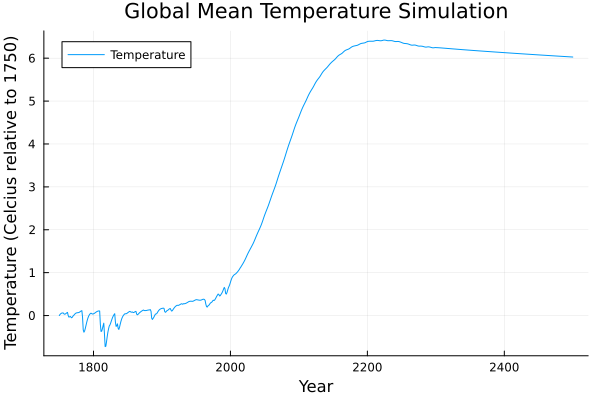

In [154]:
#Simulation Model

#define variables
c = 4.184 * 10^6 #J/K/m^2
d = 86 #m 
lambda = 2.1 #C/(W/m^2)
alpha = 0.8
delta_t = 31558152

function global_mean_temp(forcing_aerosol, forcing_non_aerosol, delta_t, c,d,lambda, alpha, t)
    F = forcing_aerosol*alpha + forcing_non_aerosol #total radiative forcing

    L = length(t)
    T = zeros(L) #make sure T is in the same formatting type as F
    for i in 1:L-1
        T[i+1] = T[i] + delta_t * (F[i] - lambda * T[i])/(c*d) 
    end
    return T
end


Temps = global_mean_temp(forcing_aerosol, forcing_non_aerosol, delta_t, c,d,lambda, alpha, t)

plot(t, Temps, label="Temperature", xlabel="Year", ylabel="Temperature (Celcius relative to 1750)", title="Global Mean Temperature Simulation", show=true)


**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

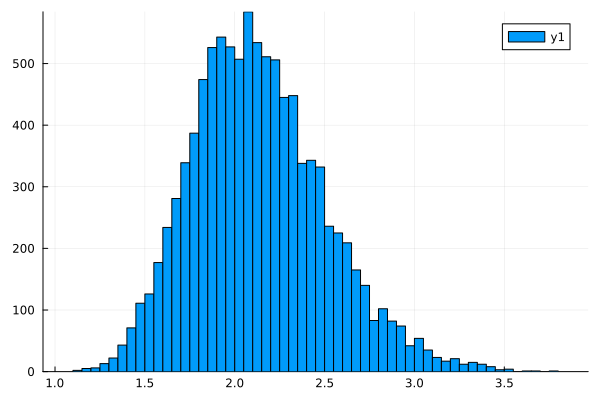

In [155]:
ff_dist = LogNormal(log(2.1), log(2)/4)
ff_samples = rand(ff_dist, 10000)
histogram(ff_samples)


In [156]:
function projected_temp(n_samples)
    temp_2100 = []
    for i = 1:n_samples
        lambda_sample = rand(ff_dist)
        
        temp = global_mean_temp(forcing_aerosol, forcing_non_aerosol, delta_t, c,d,lambda_sample, alpha, t)
        t_2100 = temp[((2100-1750)+1)]
        push!(temp_2100, t_2100)
    end

    return temp_2100
end

#lamp = projected_temp(100)

projected_temp (generic function with 1 method)

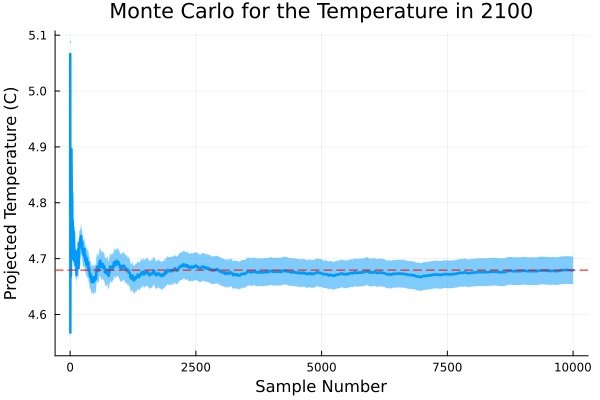

In [168]:
# Expected temperatures in 2100 using function "global_mean_temp"
n_sample = 10000
temps = projected_temp(n_sample)
monte_carlo = cumsum(temps) ./ (1:n_sample)

plot(monte_carlo, ribbon=1.96 * std(monte_carlo), xlabel="Sample Number", ylabel="Projected Temperature (C)", legend=false, title="Monte Carlo for the Temperature in 2100", linewidth=2.5)
hline!([monte_mean], color="red", linestyle=:dash) 
     

In [170]:
# Monte Carlo compared to Simulation
monte_mean = sum(temps) / length(temps)
monte_sd = std(temps)
z = 1.96
interval = z*(monte_sd/sqrt(n_sample))

simulation_projection = Temps[2100-1750+1]

display(monte_mean)
display(interval)
display(simulation_projection)



4.679455396570318

0.015125493441159484

4.632496731623587

## References

List any external references consulted, including classmates.